## Introduction
This notebook presents an analysis of an Amazon product co-purchasing network.

The project showcased the application of network analysis in a real-world e-commerce context, providing actionable insights for business strategy development. The results underscore the importance of understanding network structures and dynamics in crafting data-driven approaches to marketing, product development, and customer engagement. By integrating network science with business analytics, we can enhance decision-making processes and foster a more customer-centric approach in e-commerce.


## Insights that can gained 

Products with high centrality measures were found to be influential within the network, implying that they may be critical to driving co-purchasing behavior. These products could be targeted for promotional campaigns to leverage their influential position.

The detection of product communities can inform bundle offers or targeted marketing strategies. For instance, products within the same community could be recommended to customers who have purchased other items in that group.

Analysis of network resilience through node removal simulations highlighted the robustness of the network, as well as identified potential vulnerabilities. This can inform inventory and supply chain strategies to ensure business continuity.

By incorporating temporal data, we can further understand the evolution of the network, which could aid in anticipating future trends and planning for seasonal variations in product popularity.
## Dataset Source
https://snap.stanford.edu/data/com-Amazon.html


In [1]:
import networkx as nx
import dask
import dask.bag as db
from dask.distributed import Client
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
from ipywidgets import widgets
import plotly.graph_objs as go
import copy
import community as community_louvain
import matplotlib.cm as cm
import plotly.graph_objs as go
from IPython.display import display

## Setup and Imports
Import necessary Python packages for network analysis and initialize any required environments.

In [2]:
ungraph_file_path = 'com-amazon.ungraph.txt'

# Reading undirected graph from the edge list
G = nx.read_edgelist(ungraph_file_path, create_using=nx.Graph(), nodetype=int)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 334863
Number of edges: 925872


## Loading the Graph
Loading the graph data from a text file that contains the edge list of the Amazon product co-purchasing network.

In [3]:
# Calculating average degree of the network
average_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
average_degree


# Calculating density of the network
density = nx.density(G)
density

# Getting size of the connected components
component_sizes = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]


largest_component_size = component_sizes[0]  # Size of the largest component
top_5_component_sizes = component_sizes[:5]  # Sizes of the top 5 largest components

(largest_component_size, top_5_component_sizes, average_degree, density)



(334863, [334863], 5.529855493141971, 1.6513834036534368e-05)

## Basic Network Statistics
Computing basic statistics such as average degree and network density to understand the general properties of the network.

Average Clustering Coefficient: 0.3967

Top 10 Nodes by Degree Centrality:
     Node  Degree Centrality
0  548091           0.001639
1  458358           0.000968
2  222074           0.000767
3  199628           0.000687
4  515301           0.000681
5  291117           0.000654
6  502784           0.000648
7  296016           0.000633
8  239107           0.000612
9  436020           0.000588


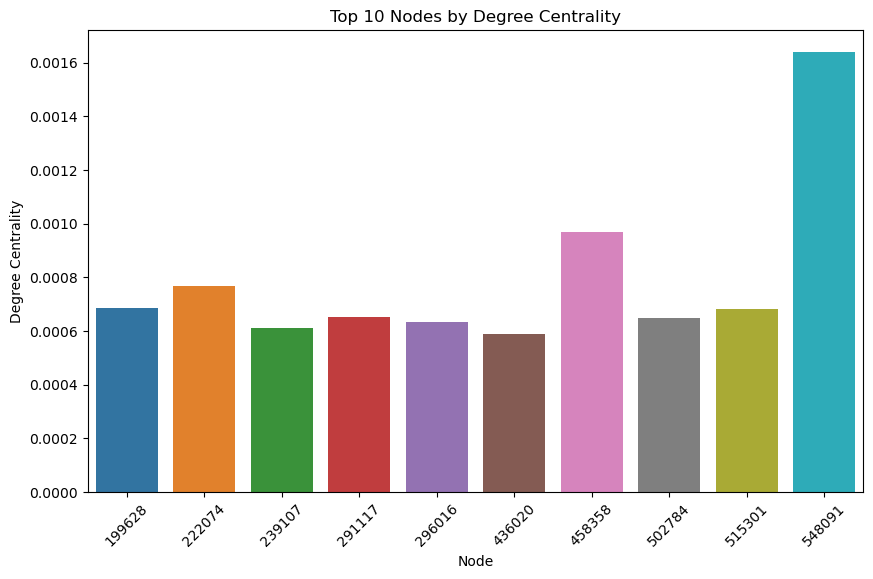

In [4]:

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Calculate the average clustering coefficient
avg_clustering_coefficient = nx.average_clustering(G)

# Get the top 10 nodes with the highest degree centrality
top_10_degree_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:10]



df_top_degree_centrality = pd.DataFrame(top_10_degree_centrality, columns=['Node', 'Degree Centrality'])

#
print(f"Average Clustering Coefficient: {avg_clustering_coefficient:.4f}")
print("\nTop 10 Nodes by Degree Centrality:")
print(df_top_degree_centrality)


plt.figure(figsize=(10, 6))
sns.barplot(x='Node', y='Degree Centrality', data=df_top_degree_centrality)
plt.xticks(rotation=45)
plt.title('Top 10 Nodes by Degree Centrality')
plt.show()


## Evaluating Network Robustness by Simulating Node Removal

In [5]:
# Function to simulate the removal of a node and calculate the size of the largest component
def simulate_removal(graph, node):
   
    H = copy.deepcopy(graph)  # Create a copy of the graph to avoid altering the original graph
    H.remove_node(node) # Remove the node
    components = sorted(nx.connected_components(H), key=len, reverse=True) # Finding all connected components, sorted by size   
    return len(components[0]) if components else 0   # Return the size of the largest component


impact_of_removal = []

# Iterating over the top 10 critical nodes
for node, _ in top_10_degree_centrality:
    largest_component_size_after_removal = simulate_removal(G, node)
    impact_of_removal.append((node, largest_component_size_after_removal))


impact_of_removal


[(548091, 334629),
 (458358, 334855),
 (222074, 334832),
 (199628, 334860),
 (515301, 334857),
 (291117, 334841),
 (502784, 334858),
 (296016, 334846),
 (239107, 334857),
 (436020, 334862)]

## Analyzing Connected Components
Identifying and analyzing the connected components of the network, which can reveal the structure and connectivity of the product co-purchasing relationships.

<Figure size 2000x2000 with 0 Axes>

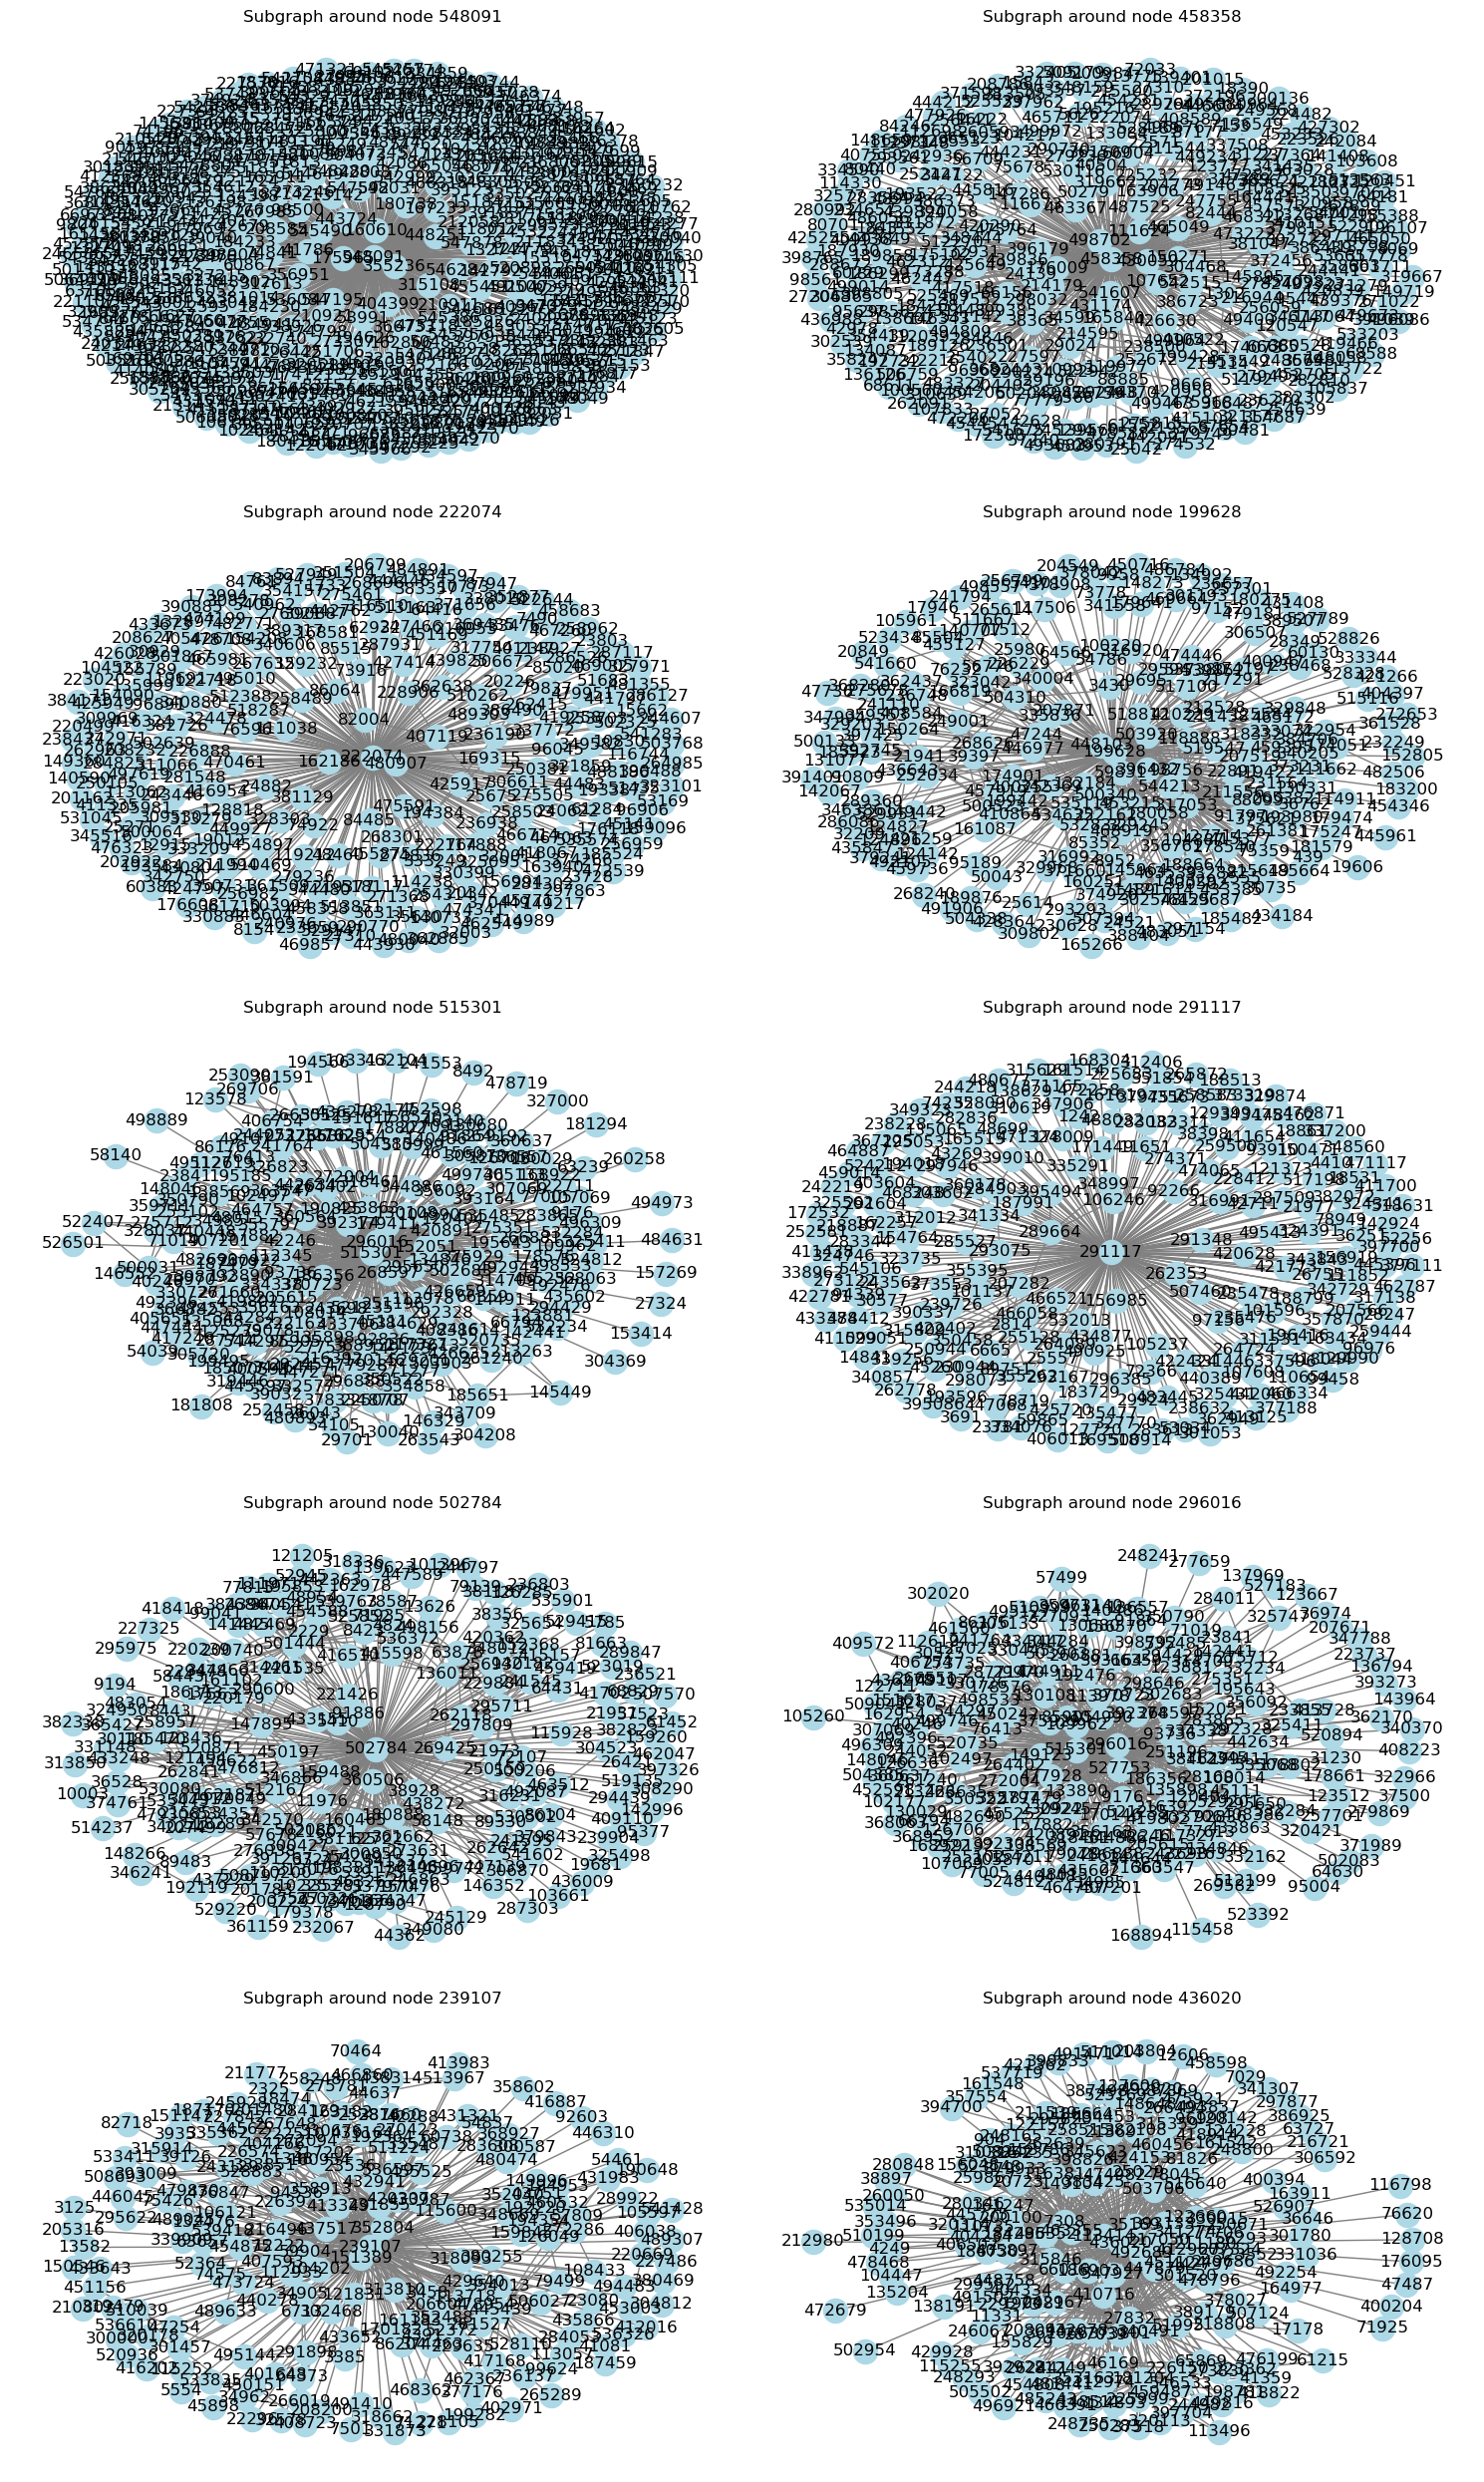

In [6]:
plt.figure(figsize=(20, 20))

n_top_nodes = len(top_10_degree_centrality)


fig, axes = plt.subplots(nrows=n_top_nodes//2, ncols=2, figsize=(15, n_top_nodes*2.5))  # Create subplots

axes = axes.flatten()  # Flatten the axes array for easy iteration

for index, (node, centrality) in enumerate(top_10_degree_centrality):
    subgraph_nodes = list(G.neighbors(node)) + [node]
    subgraph = G.subgraph(subgraph_nodes)
    
    pos = nx.spring_layout(subgraph)
    ax = axes[index]
    nx.draw(subgraph, pos, ax=ax, with_labels=True, node_color='lightblue', edge_color='gray')
    ax.set_title(f'Subgraph around node {node}')
    

plt.tight_layout()  # Adjusting layout to prevent overlap
plt.show()

## Advanced Network Metrics
Calculating advanced network metrics such as the average clustering coefficient, network diameter, and average path length.

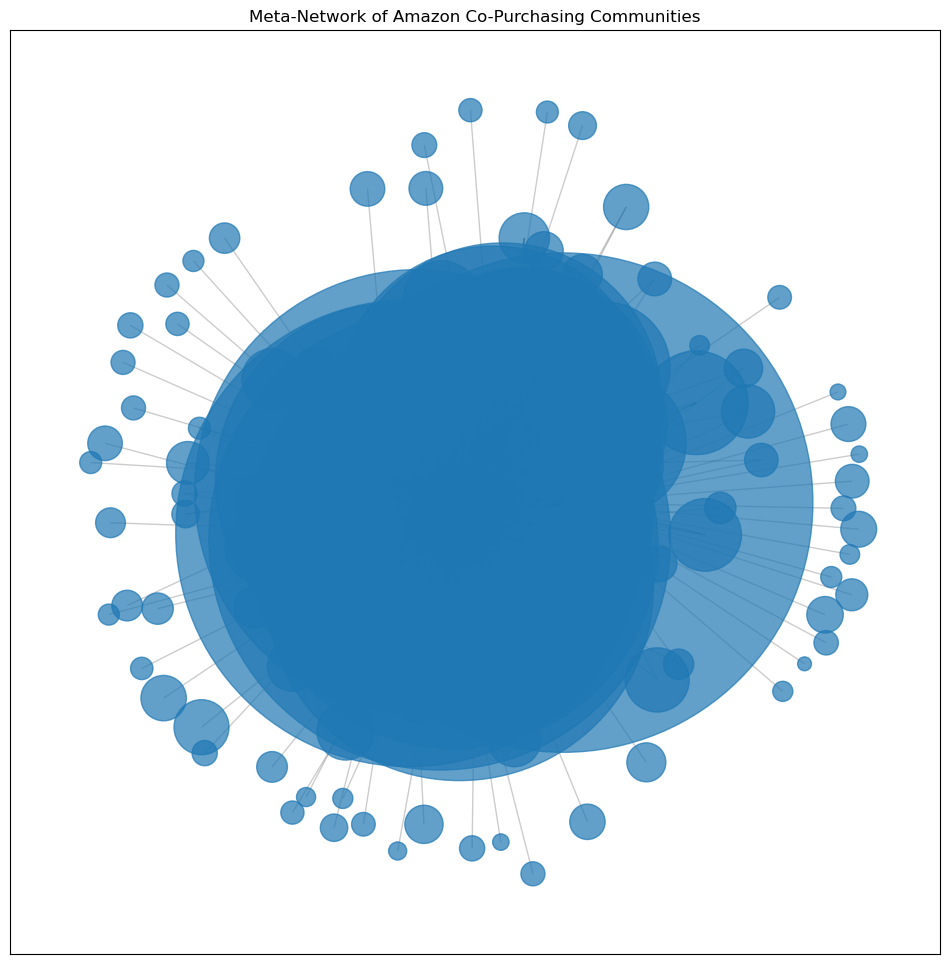

In [7]:
partition = community_louvain.best_partition(G)
meta_network = nx.Graph()


for node, com_id in partition.items():
    meta_network.add_node(com_id)
    for neighbor in G.neighbors(node):
        neighbor_com_id = partition[neighbor]
        if com_id != neighbor_com_id:
            meta_network.add_edge(com_id, neighbor_com_id)


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(meta_network)


node_sizes = [len([n for n in partition if partition[n] == com]) * 10 for com in meta_network.nodes()]
nx.draw_networkx_nodes(meta_network, pos, node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(meta_network, pos, alpha=0.2)
plt.title('Meta-Network of Amazon Co-Purchasing Communities')
plt.show()


## Visualization
Visualization of the network to better understand its structure. This section include visualizing specific nodes, edges, or subgraphs.

In [8]:
# Initializing Dask client
client = Client()

# Load or define your graph 'G'
partition = community_louvain.best_partition(G)


C:\Users\Rishiraj\Anaconda3\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58182 instead
  warnings.warn(


## Community Detection
Performing community detection to identify groups of products that are more closely related to each other in the co-purchasing network.

In [9]:
def calculate_layout(nodes):
    H = G.subgraph(nodes)
    pos = nx.spring_layout(H)
    return pos


In [10]:
def precalculate_layouts_dask(G, partition):
    communities = {}
    for node, com_id in partition.items():
        if com_id not in communities:
            communities[com_id] = []
        communities[com_id].append(node)
    
    futures = [client.submit(calculate_layout, nodes) for nodes in communities.values()]
    results = client.gather(futures)
    
    pos_community = {com_id: result for com_id, result in zip(communities.keys(), results)}
    
    return pos_community


pos_community = precalculate_layouts_dask(G, partition)


C:\Users\Rishiraj\Anaconda3\lib\site-packages\distributed\client.py:3106: UserWarning: Sending large graph of size 19.57 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\Rishiraj\Anaconda3\lib\site-packages\distributed\client.py:3106: UserWarning: Sending large graph of size 19.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\Rishiraj\Anaconda3\lib\site-packages\distributed\client.py:3106: UserWarning: Sending large graph of size 19.52 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\Rishiraj\Anaconda3\lib\site-packages\distributed\client.py:3106: UserWarning: Sending large graph of size 19.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\Rishiraj\Anaconda3\lib\site-packages\distributed\client.py:3106: Us

In [11]:
def plot_community_subgraph(community_id):
    community_pos = pos_community[community_id]
    nodes_in_community = [node for node in partition if partition[node] == community_id]
    subG = G.subgraph(nodes_in_community)
    
    edge_x = []
    edge_y = []
    for edge in subG.edges():
        x0, y0 = community_pos[edge[0]]
        x1, y1 = community_pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')

    node_x = []
    node_y = []
    node_text = []  
    for node in subG.nodes():
        x, y = community_pos[node]
        node_x.append(x)
        node_y.append(y)
        
        node_text.append(str(node))  
    
    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', text=node_text,  # Add node_text here for hover information
                            marker=dict(showscale=False, color='blue', size=10, line=dict(width=2)))

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(showlegend=False, hovermode='closest', margin=dict(b=0,l=0,r=0,t=0),
                                     xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                     yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

    fig.update_layout(title_text=f'Community {community_id} Subgraph', title_x=0.5)
    fig.show()


In [12]:
community_dropdown = widgets.Dropdown(options=list(set(partition.values())), description='Community:')
output = widgets.Output()

def dropdown_eventhandler(change):
    output.clear_output()
    with output:
        plot_community_subgraph(change.new)

community_dropdown.observe(dropdown_eventhandler, names='value')
display(community_dropdown, output)


Dropdown(description='Community:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …

Output()